# INUMET - Precipitation Data
 - **@author**: Mario Garcia (mario.garcia@utec.edu.uy)
 - **@description**: Procesamiento de los datos RAW de los pluviómetros. Anexo de lat/lon a los dataset de los pluviómetros
 - **Data Source**:  https://www.inumet.gub.uy/institucional/transparencia/solicitud-informacion-meteorologica
 - **Output**: 
  - **inumet_daily_2000_2020.nc** (Dataset netCDF unificado de las estaciones inumet con anexo de geodatos de latitud y longitud)
  - inumet_raw_2000_2020.pkl (Dataset Pickle unificado de las estaciones inumet sin procesamiento)
  - mater_inumet_daily_2000_2020.nc (Dataset netCDF inumet_daily_2000_2020.nc que ha pasado control de calidad y puede ser utilizado para la próxima etapa)

 - **Input**: 
   - master_data_raw_inumet.zip (Excel con datos raw de las estaciones)
   - master_geodata_raw_inumet.json (Json con geodatos de las  estaciones)
 - **@version**: v1.3
 - **@date**: 2022-08-10,  2022-08-06, 2022-08-01, 2022-07-30, 2022-07-26   

## Setup

In [1]:
dir_google_drive = "/content/drive/MyDrive/ValidacionProductosSatelitales(VPS)/Proyecto Colab/03 - DataLake/"
dir_google_drive_output = dir_google_drive+'/datasets/output/'
dir_data = './data/'
dir_data_source = dir_data+'/source/'
dir_var = './var/'
dir_download = dir_var+'/download/'
dir_output = dir_var+'/output/'
dir_log = dir_var+'/log/'


### Libraries

In [2]:
!pip install geopandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 16.7 MB 27.5 MB/s 
     |████████████████████████████████| 6.3 MB 70.2 MB/s 


In [3]:
# Data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Utils
import os 
import shutil
import glob

# Zip
import zipfile

# NetCDF
import xarray  as xr

# GEO MAPS
# https://jcutrer.com/python/learn-geopandas-plotting-usmaps
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [4]:
def get_geometry_uruguay():
  df_world_shapes = gpd.read_file(dir_data+"/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp")
  df_uruguay_shapes = df_world_shapes[ df_world_shapes['ISO2'] == 'UY']
  # df_uruguay_shapes
  polygon_uruguay = df_uruguay_shapes['geometry']
  return polygon_uruguay
  # polygon_uruguay = geometry[210]
  # return gpd.GeoSeries(polygon_uruguay)

### Init

In [5]:
!rm -rf "$dir_data"

!mkdir -p "$dir_data"
!mkdir -p "$dir_data_source"
!mkdir -p "$dir_download"
!mkdir -p "$dir_output"
!mkdir -p "$dir_log"

!mkdir -p "$dir_data"/TM_WORLD_BORDERS
!wget  -O "$dir_download"/TM_WORLD_BORDERS-0.3.zip  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip 
!unzip -o "$dir_download"/TM_WORLD_BORDERS-0.3.zip -d "$dir_data"/TM_WORLD_BORDERS 


--2022-08-10 23:04:33--  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
Resolving thematicmapping.org (thematicmapping.org)... 67.20.120.230
Connecting to thematicmapping.org (thematicmapping.org)|67.20.120.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3464707 (3.3M) [application/zip]
Saving to: ‘./var//download//TM_WORLD_BORDERS-0.3.zip’

./var//download//TM 100%[===================>]   3.30M  7.60MB/s    in 0.4s    

2022-08-10 23:04:34 (7.60 MB/s) - ‘./var//download//TM_WORLD_BORDERS-0.3.zip’ saved [3464707/3464707]

Archive:  ./var//download//TM_WORLD_BORDERS-0.3.zip
  inflating: ./data//TM_WORLD_BORDERS/Readme.txt  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.dbf  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.prj  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shx  


## Download Data

In [6]:
filename = dir_download+"/master_data_raw_inumet.zip"
!gdown -O $filename "1_eYQmYLEsiUTFCQLmWPOrKgipabMkxm3"

Downloading...
From: https://drive.google.com/uc?id=1_eYQmYLEsiUTFCQLmWPOrKgipabMkxm3
To: /content/var/download/master_data_raw_inumet.zip
100% 4.18M/4.18M [00:00<00:00, 40.2MB/s]


In [7]:
# unzip data
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(dir_data_source)

In [8]:
!mv "$dir_data_source"/Precipitaciones/* "$dir_data_source"

### Pre Processing

In [9]:
filename_estaciones_data = dir_data+"/master_geodata_raw_inumet.json"
!gdown -O $filename_estaciones_data "1m-oKeQYWZu__9iU6usN0KsT0zSusy8AD"

Downloading...
From: https://drive.google.com/uc?id=1m-oKeQYWZu__9iU6usN0KsT0zSusy8AD
To: /content/data/master_geodata_raw_inumet.json
100% 488k/488k [00:00<00:00, 89.8MB/s]


In [10]:
import json 

with open(filename_estaciones_data,'r') as f:
    data = json.loads(f.read()) 

df_estaciones = pd.json_normalize(data, record_path =['estaciones']) 
df_estaciones = df_estaciones[['Estacion','NombreEstacion','codigoPluviometrico','Latitud','Longitud']]
df_estaciones = df_estaciones.rename(columns = {'NombreEstacion':'Nombre', 'Latitud':'lat','Longitud':'lon','codigoPluviometrico':'Cod. Pluvio'})
df_estaciones

,Estacion,Nombre,Cod. Pluvio,lat,lon
0,BALTASAR BRUM,Baltasar Brum,1092A,-30.719000,-57.325000
1,18 DE JULIO,18 de Julio,2421,-33.720000,-53.550000
2,19 DE ABRIL,19 de Abril,2770,-34.362300,-54.069800
3,25 DE AGOSTO,25 de Agosto,2748A,-34.412000,-56.398000
4,ACEGUA,Acegua,1496,-31.874100,-54.161300
...,...,...,...,...,...
524,melog3,Melo G3,None,-32.366750,-54.192570
525,argitasg3,Artigas G3,None,-30.399110,-56.512670
526,atlantidag3,Atlántida G3,None,-34.779720,-55.752770
527,treintaytresg3,Treinta y Tres G3,None,-33.196820,-54.348150


### Merge Estaciones and Precipitations

In [11]:
df_gauge = None

# null_values = 'TRAZA'

files = glob.glob(dir_data_source+'/*.xlsx')  
for f in files:
  print("Processing: ", f)

  _df_gauge = pd.read_excel(f)
  
  # check null value TRAZA
  _df_gauge.loc[_df_gauge['[mm]'] == 'TRAZA', '[mm]'] = -999

  _df_gauge['[mm]'] = _df_gauge['[mm]'].astype(float)
  _df_gauge['Cod. Pluvio'] = _df_gauge['Cod. Pluvio'].astype(str)

  # Quick fix
  _df_gauge.loc[_df_gauge['Cod. Pluvio'] == "2297.0"	, 'Cod. Pluvio'] = "2297"
  _df_gauge.drop(_df_gauge[_df_gauge['Estación'] == 'Dato faltante.'].index, inplace=True)

  _df_gauge = _df_gauge.join(df_estaciones[['Cod. Pluvio','lat','lon']].set_index('Cod. Pluvio'),on="Cod. Pluvio") 
  
  # display(_df_gauge[:3])
  if df_gauge is None:
    df_gauge = _df_gauge
  else:
    df_gauge = df_gauge.append(_df_gauge)

df_gauge = df_gauge[['Estación', 'Cod. Pluvio', 'Fecha', '[mm]', 'Comentario', 'lat', 'lon']]
df_gauge

Processing:  ./data//source/1622830248834-Colonia Miguelete 2000-2021.xlsx
Processing:  ./data//source/1622830248879-E.Met.Melilla 2000-2021.xlsx
Processing:  ./data//source/1622830248830-Cerro Colorado 2000-2021.xlsx
Processing:  ./data//source/1622830248902-E.Met.Rivera 2000-2021.xlsx
Processing:  ./data//source/1622830248875-E.Met.Florida 2000-2021.xlsx
Processing:  ./data//source/1622830248887-E.Met.Mercedes 2000-2021.xlsx
Processing:  ./data//source/1622830248937-Pueblo Centenario 2000-2021.xlsx
Processing:  ./data//source/1622830248918-E.Met.Treinta y Tres 2000-2021.xlsx
Processing:  ./data//source/1622830248933-Manuel Mal Abrigo 2000-2021.xlsx
Processing:  ./data//source/1622830248910-E.Met.Salto 2000-2021.xlsx
Processing:  ./data//source/1622830248895-E.Met.Prado 2000-2021.xlsx
Processing:  ./data//source/1622830248914-E.Met.San Jose 2000-2021.xlsx
Processing:  ./data//source/1622830248944-San Jacinto 2000-2021.xlsx
Processing:  ./data//source/1622830248863-E.Met.Carrasco 2000-

,Estación,Cod. Pluvio,Fecha,[mm],Comentario,lat,lon
0,Colonia Miguelete,2570,2000-01-01,0.0,NaN,-34.006,-57.645
1,Colonia Miguelete,2570,2000-01-02,0.0,NaN,-34.006,-57.645
2,Colonia Miguelete,2570,2000-01-03,0.0,NaN,-34.006,-57.645
3,Colonia Miguelete,2570,2000-01-04,0.0,NaN,-34.006,-57.645
4,Colonia Miguelete,2570,2000-01-05,0.0,NaN,-34.006,-57.645
...,...,...,...,...,...,...,...
7667,25 de Agosto,2748A,2020-12-28,0.0,NaN,-34.412,-56.398
7668,25 de Agosto,2748A,2020-12-29,10.0,NaN,-34.412,-56.398
7669,25 de Agosto,2748A,2020-12-30,1.5,NaN,-34.412,-56.398
7670,25 de Agosto,2748A,2020-12-31,0.0,NaN,-34.412,-56.398


In [12]:
df_gauge = df_gauge.set_index(['lat', 'lon','Fecha'])
df_gauge

Estación Cod. Pluvio  [mm] Comentario
lat     lon     Fecha                                                     
-34.006 -57.645 2000-01-01  Colonia Miguelete        2570   0.0        NaN
                2000-01-02  Colonia Miguelete        2570   0.0        NaN
                2000-01-03  Colonia Miguelete        2570   0.0        NaN
                2000-01-04  Colonia Miguelete        2570   0.0        NaN
                2000-01-05  Colonia Miguelete        2570   0.0        NaN
...                                       ...         ...   ...        ...
-34.412 -56.398 2020-12-28       25 de Agosto       2748A   0.0        NaN
                2020-12-29       25 de Agosto       2748A  10.0        NaN
                2020-12-30       25 de Agosto       2748A   1.5        NaN
                2020-12-31       25 de Agosto       2748A   0.0        NaN
                2021-01-01       25 de Agosto       2748A   0.0        NaN

[214816 rows x 4 columns]

In [13]:
# Check duplicated
df_gauge[df_gauge.index.duplicated()]

,,,Estación,Cod. Pluvio,[mm],Comentario
lat,lon,Fecha,,,,


In [14]:
# Importante para poder eliminar duplicados hay que realizar un reset de los indices
df_gauge = df_gauge.reset_index()
df_gauge.drop_duplicates(subset=['Fecha','lat','lon'], inplace=True, keep='first') 
df_gauge

,lat,lon,Fecha,Estación,Cod. Pluvio,[mm],Comentario
0,-34.006,-57.645,2000-01-01,Colonia Miguelete,2570,0.0,NaN
1,-34.006,-57.645,2000-01-02,Colonia Miguelete,2570,0.0,NaN
2,-34.006,-57.645,2000-01-03,Colonia Miguelete,2570,0.0,NaN
3,-34.006,-57.645,2000-01-04,Colonia Miguelete,2570,0.0,NaN
4,-34.006,-57.645,2000-01-05,Colonia Miguelete,2570,0.0,NaN
...,...,...,...,...,...,...,...
214811,-34.412,-56.398,2020-12-28,25 de Agosto,2748A,0.0,NaN
214812,-34.412,-56.398,2020-12-29,25 de Agosto,2748A,10.0,NaN
214813,-34.412,-56.398,2020-12-30,25 de Agosto,2748A,1.5,NaN
214814,-34.412,-56.398,2020-12-31,25 de Agosto,2748A,0.0,NaN


In [15]:
# df_gauge.to_csv('df_gauge_thirt.csv')

In [16]:
# restauramos los indices
df_gauge.set_index(['Fecha','lat','lon'], inplace=True)
df_gauge

,,,Estación,Cod. Pluvio,[mm],Comentario
Fecha,lat,lon,,,,
2000-01-01,-34.006,-57.645,Colonia Miguelete,2570,0.0,NaN
2000-01-02,-34.006,-57.645,Colonia Miguelete,2570,0.0,NaN
2000-01-03,-34.006,-57.645,Colonia Miguelete,2570,0.0,NaN
2000-01-04,-34.006,-57.645,Colonia Miguelete,2570,0.0,NaN
2000-01-05,-34.006,-57.645,Colonia Miguelete,2570,0.0,NaN
...,...,...,...,...,...,...
2020-12-28,-34.412,-56.398,25 de Agosto,2748A,0.0,NaN
2020-12-29,-34.412,-56.398,25 de Agosto,2748A,10.0,NaN
2020-12-30,-34.412,-56.398,25 de Agosto,2748A,1.5,NaN


### Export Raw Inumet

In [17]:
file_pkl = dir_output+'inumet_raw_2000_2020.pkl'
df_gauge.to_pickle(file_pkl,compression='gzip')
!cp "$file_pkl" "$dir_google_drive_output" 

## Config

In [18]:
var_lat = 'lat'
var_lon = 'lon'
var_time = 'Fecha'
var_precipitation = '[mm]'

var_null_values = -598

var_null_values_from_source = -999

## Process Data

In [19]:
ds_xr_multi = df_gauge.to_xarray()
ds_xr_multi

<xarray.Dataset>
Dimensions:      (Fecha: 7672, lat: 28, lon: 28)
Coordinates:
  * Fecha        (Fecha) datetime64[ns] 2000-01-01 2000-01-02 ... 2021-01-01
  * lat          (lat) float64 -34.97 -34.86 -34.83 ... -31.44 -30.9 -30.4
  * lon          (lon) float64 -58.07 -58.04 -58.03 ... -54.39 -54.31 -54.19
Data variables:
    Estación     (Fecha, lat, lon) object nan nan nan nan ... nan nan nan nan
    Cod. Pluvio  (Fecha, lat, lon) object nan nan nan nan ... nan nan nan nan
    [mm]         (Fecha, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Comentario   (Fecha, lat, lon) object nan nan nan nan ... nan nan nan nan

In [20]:
ds_xr_multi[var_precipitation].data

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

### Standarize

In [21]:
names = {var_time:'time', var_precipitation:'precipitation', var_lat:'lat', var_lon:'lon'}
ds_xr_multi = ds_xr_multi.rename(names)
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7672, lat: 28, lon: 28)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2021-01-01
  * lat            (lat) float64 -34.97 -34.86 -34.83 ... -31.44 -30.9 -30.4
  * lon            (lon) float64 -58.07 -58.04 -58.03 ... -54.39 -54.31 -54.19
Data variables:
    Estación       (time, lat, lon) object nan nan nan nan ... nan nan nan nan
    Cod. Pluvio    (time, lat, lon) object nan nan nan nan ... nan nan nan nan
    precipitation  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Comentario     (time, lat, lon) object nan nan nan nan ... nan nan nan nan

In [22]:
ds_xr_multi = ds_xr_multi[['precipitation']]
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7672, lat: 28, lon: 28)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2021-01-01
  * lat            (lat) float64 -34.97 -34.86 -34.83 ... -31.44 -30.9 -30.4
  * lon            (lon) float64 -58.07 -58.04 -58.03 ... -54.39 -54.31 -54.19
Data variables:
    precipitation  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [23]:
ds_xr_multi['precipitation'] = ds_xr_multi['precipitation'].astype(np.float32)
ds_xr_multi['lat'] = ds_xr_multi['lat'].astype(np.float32)
ds_xr_multi['lon'] = ds_xr_multi['lon'].astype(np.float32)
ds_xr_multi

<xarray.Dataset>
Dimensions:        (time: 7672, lat: 28, lon: 28)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2021-01-01
  * lat            (lat) float32 -34.97 -34.86 -34.83 ... -31.44 -30.9 -30.4
  * lon            (lon) float32 -58.07 -58.04 -58.03 ... -54.39 -54.31 -54.19
Data variables:
    precipitation  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

### Filtre

In [24]:
# replace all missing values with -999
mask = (ds_xr_multi['precipitation'] == var_null_values_from_source)
ds_xr_multi['precipitation'] = xr.where(mask, var_null_values, ds_xr_multi['precipitation'])
ds_xr_multi_query = ds_xr_multi

In [25]:
# Uruguay box
lat_max = -30; lat_min = -35
lon_max = -53; lon_min = -59

ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lat'] < lat_max, drop=True)
ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lat'] > lat_min, drop=True)

ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lon'] < lon_max, drop=True)
ds_xr_multi_query = ds_xr_multi_query.where(ds_xr_multi_query['lon'] > lon_min, drop=True)

In [26]:
ds_xr_multi_query_done = ds_xr_multi_query.compute()
ds_xr_multi_query_done

<xarray.Dataset>
Dimensions:        (time: 7672, lat: 28, lon: 28)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2021-01-01
  * lat            (lat) float32 -34.97 -34.86 -34.83 ... -31.44 -30.9 -30.4
  * lon            (lon) float32 -58.07 -58.04 -58.03 ... -54.39 -54.31 -54.19
Data variables:
    precipitation  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

## Export

In [27]:
encoding = {'precipitation': {
                  #'_FillValue': var_null_values,      NOT SUPPORTED by xArray
                  #'missing_value': var_null_values,   NOT SUPPORTED by xArray
                  # 'chunksizes': (1, 8, 10),
                  'complevel': 9,
                  'zlib': True}
            }             
file_nc = dir_output+'/inumet_daily_2000_2020.nc'
ds_xr_multi_query_done.to_netcdf(file_nc,mode="w", encoding=encoding)

In [28]:
# Export to drive (optional)
!cp "$file_nc" "$dir_google_drive_output" 

## Plot

In [29]:
file_nc = dir_google_drive_output+'/inumet_daily_2000_2020.nc' 

df_xr_raw = xr.open_dataset(file_nc, mask_and_scale=False) # !Important for Null Values
# !Important
mask = df_xr_raw.precipitation > 0
df_xr = df_xr_raw.where( mask )

# df_xr = xr.open_dataset(file_nc, mask_and_scale=True) # !Important for Null Values -598
# df_xr

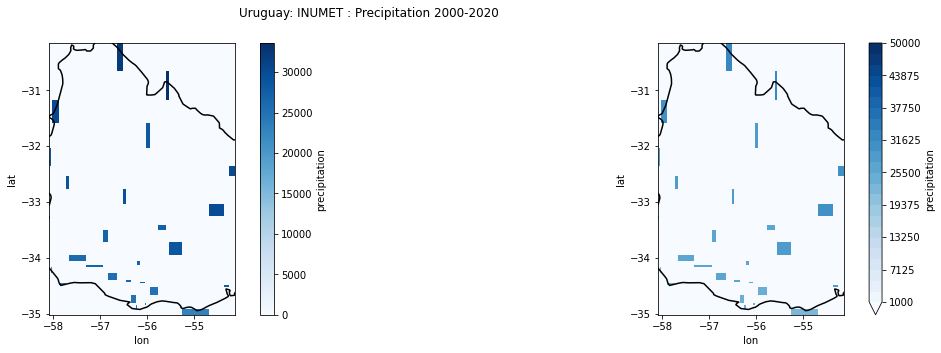

In [30]:
# coordinate reference system
crs={'init':'epsg:4326'}

geodf_shape = get_geometry_uruguay()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))  

df_xr_acc = df_xr.sum(dim="time")['precipitation']


df_xr_acc.plot(ax=axs[0], x="lon", y="lat", cmap="Blues")#, levels=20)
geodf_shape.boundary.plot(ax=axs[0], color="black")

df_xr_acc.plot(ax=axs[1], x="lon", y="lat", cmap="Blues", levels=np.linspace(1000, 50000, 25))
geodf_shape.boundary.plot(ax=axs[1], color="black")

prec_max = np.round(float(df_xr_acc.max().data), 2)
prec_min = np.round(float(df_xr_acc.min().data), 2)
fig.suptitle(f'Uruguay: INUMET : Precipitation 2000-2020', fontsize=12)
plt.show()